In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import cProfile
import time

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch

from utils.combine import CombineRadial, CombineRadialSpecies, CombineSpecies
from utils.dataset import AtomisticDataset, create_dataloader
from utils.linear import LinearModel
from utils.operations import SumStructures, remove_gradient
from utils.soap import PowerSpectrum, CompositionFeatures

torch.set_default_dtype(torch.float64)

In [3]:
n_test = 100
n_train = 200

frames = ase.io.read("data/data_shuffle.xyz", f":{n_test + n_train}")

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = torch.tensor(
    [frame.info["energy"] for frame in train_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

test_energies = torch.tensor(
    [frame.info["energy"] for frame in test_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

train_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype())
    for frame in train_frames
]

test_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype()) 
    for frame in test_frames
]

print(f"using {n_train} training frames")

using 200 training frames


In [4]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": all_species,
# }

HYPERS_SMALL = {
    "cutoff": 4.0,
    "max_angular": 0,
    "max_radial": 12,
    "atomic_gaussian_width": 0.3,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight" : 0,
    # # TODO: implement this in rascaline itself
    # "radial_per_angular": {
    #     # l: n
    #     0: 10,
    #     1: 8,
    #     2: 8,
    #     3: 4,
    #     4: 4,
    # }
}

# Manual model

In [5]:
from rascaline import SphericalExpansion
calculator = SphericalExpansion(**HYPERS_SMALL)
descriptor = calculator.compute(frames)
descriptor.keys_to_properties(["species_neighbor"])

AttributeError: 'Descriptor' object has no attribute 'keys_to_properties'

In [17]:
my_species = np.unique(descriptor.keys['species_center'])
my_species = { sp:i for i,sp in enumerate(my_species)  }

In [18]:
X1 = np.zeros((len(frames), len(my_species)))
for key, block in descriptor:
    _, specie = key
    idx, cnt = np.unique(block.samples['structure'], return_counts=True)    
    X1[idx,all_species[specie]] += cnt

IndexError: index 74 is out of bounds for axis 1 with size 25

In [19]:
y = np.asarray([f.info['energy'] for f in frames])

In [20]:
from sklearn.linear_model import RidgeCV

In [ ]:
X = X1

In [ ]:
ridge = RidgeCV(alphas=np.geomspace(1e-5,1e3,13), cv=4)

In [ ]:
ridge.fit(X[:n_train], y[:n_train])

In [ ]:
ridge.alpha_

In [ ]:
yp = ridge.predict(X)

In [ ]:
plt.plot(y[n_train:],yp[n_train:], "r.")
plt.plot(y[:n_train],yp[:n_train], "b.")

In [ ]:
np.sqrt(np.mean(np.abs(y-yp)[n_train:]))/len(frames[0])

In [8]:
ridge.coef_[:25]

NameError: name 'ridge' is not defined

In [9]:
plt.plot(y, X1@ridge.coef_[:25], 'b.')

NameError: name 'y' is not defined

# Optimization loop, energies only

In [5]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

In [6]:
train_dataset = AtomisticDataset(train_frames, all_species, HYPERS_SMALL, train_energies, radial_spectrum_n_max=12)
test_dataset = AtomisticDataset(train_frames, all_species, HYPERS_SMALL, train_energies, radial_spectrum_n_max=12)

HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
HYPERS_GRAD["gradients"] = False
train_dataset_grad = AtomisticDataset(train_frames, all_species, HYPERS_GRAD, train_energies, train_forces)
test_dataset_grad = AtomisticDataset(test_frames, all_species, HYPERS_GRAD, test_energies, test_forces)

In [7]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

train_dataloader_single_frame = create_dataloader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    device=device,
)

train_dataloader_grad = create_dataloader(
    train_dataset_grad,
    batch_size=50,
    shuffle=True,
    device=device,
)

train_dataloader_grad_no_batch = create_dataloader(
    train_dataset_grad,
    batch_size=len(train_dataset_grad),
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    device=device,
)

test_dataloader_grad = create_dataloader(
    test_dataset_grad,
    batch_size=50,
    shuffle=False,
    device=device,
)

In [8]:
def loss_optimizer(predicted, actual, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    return loss

def loss_optimizer_forces(predicted, actual, predicted_f, actual_f, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    loss += torch.linalg.norm(predicted_f.flatten() - actual_f.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    return loss

def loss_mae(predicted, actual):
    return torch.mean(torch.abs(predicted.flatten() - actual.flatten()))

def loss_rmse(predicted, actual):
    return torch.sqrt(torch.mean((predicted.flatten() - actual.flatten())**2))

In [9]:
class CompositionLinearModel(torch.nn.Module):
    def __init__(self, 
        all_species,
        regularizer,
        optimizable_weights=True,
        random_initial_weights=False,
    ):
        super().__init__()

        self.composition = CompositionFeatures(all_species)
        self.model = LinearModel(
            regularizer=regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )
        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights        
        
    def forward(self, frames):
                
        energies, _ = self.model(self.composition(frames))
        return energies, None
    
    def initialize_model_weights(self, frames, energies, forces=None):
        self.model.initialize_model_weights(self.composition(frames), energies, forces)        

In [10]:
TORCH_REGULARIZER = 1e-2

model = CompositionLinearModel(
    all_species=all_species,
    regularizer=TORCH_REGULARIZER,
    random_initial_weights=True,
    optimizable_weights=True,
)

In [11]:
model.to(device=device, dtype=torch.get_default_dtype())
for f,_,_,e,_ in train_dataloader_single_frame:
    model.initialize_model_weights(f,e)

In [12]:
lr = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.model.parameters(), lr=lr, line_search_fn="strong_wolfe")

all_losses = []

filename = f"{model.__class__.__name__}-composition-{n_train}-train"

if model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [15]:
for epoch in range(20):
    epoch_start = time.time()

    def single_step():
        print(np.linalg.norm(model.model.weights.grad))
        optimizer.zero_grad()
        for frame, _, _, energies, _ in train_dataloader:        
            predicted, _ = model(frame)
            #print(predicted[0], energies[0])
            loss = loss_optimizer(
                predicted, 
                energies, 
                TORCH_REGULARIZER, 
                model.model.weights
            )
            loss.backward(retain_graph=False)

        return loss
            
    loss = optimizer.step(single_step)
    loss = loss.item()
    all_losses.append(loss)

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            predicted = []
            reference = []
            for frame, _, _, energies, _ in test_dataloader:
                reference.append(energies)
                predicted_e, _ = model(frame)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            mae = loss_mae(predicted, reference)

            output.write(f"{n_epochs_total} {loss} {mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss:.4}, test mae={mae:.4}")
    
    del frame, loss, mae
        
    n_epochs_total += 1

0.0
4.924360454009548
4.173389387062961
3.7558368725928726
3.3801259494358127
3.041943409969206
2.7376466887337023
2.4637492690021427
2.217292875645587
1.9954611279928922
1.7958511207764773
1.6161877785536336
1.454519611243967
1.309008530264181
1.1780700239524675
1.0602187776810035
0.9541685606101734
0.8587188960001179
0.7728259274582367
0.695519212167399
0.6259517798955363
epoch 3 took 9.112s, optimizer loss=2.945e+04, test mae=9.501
0.5633390034420475
0.5633390034425313
0.5069937996030831
0.4562816708982464
0.4106453381941635
0.36957162685632655
0.3326086113723829
0.29934118021465694
0.2694028963734709
0.24245792620709927
0.2182091869222831
0.19638494784402225
0.17674438033401227
0.15906759528383266
0.14315938500830475
0.128841792594773
0.11595660243674415
0.10435977970316983
0.09392310013825589
0.08452997476677641
0.07607649213823037
epoch 4 took 10.75s, optimizer loss=2.945e+04, test mae=9.501
0.0684682720304074
0.06846827203017335
0.061621110082633865
0.055458815970108905
0.049911

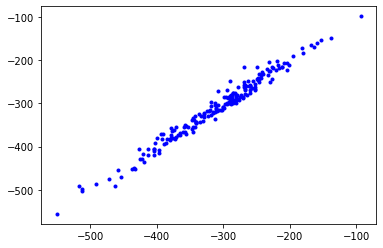

In [16]:
plt.plot(predicted, reference, 'b.')

# Predicting forces with forward propagation

In [ ]:
def evaluate_model_with_forces(model, dataloader):
    predicted_e = []
    reference_e = []
    predicted_f = []
    reference_f = []
    for spherical_expansions, energies, forces in dataloader:
        reference_e.append(energies)
        reference_f.append(forces)
        e, f = model(spherical_expansions, forward_forces=True)
        predicted_e.append(e)
        predicted_f.append(f)

    reference_e = torch.vstack(reference_e)
    predicted_e = torch.vstack(predicted_e)

    reference_f = torch.vstack(reference_f)
    predicted_f = torch.vstack(predicted_f)

    return reference_e, predicted_e, reference_f, predicted_f

In [ ]:
def parity_plots(reference_e, predicted_e, reference_f, predicted_f):
    predicted_e = predicted_e.detach()
    predicted_f = predicted_f.detach()

    fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

    mae = loss_mae(predicted_e, reference_e)
    rmse = loss_rmse(predicted_e, reference_e)
    ax_e.scatter(reference_e.cpu(), predicted_e.cpu())
    x = (torch.min(reference_e.flatten()).item(), torch.max(reference_e.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    mae = loss_mae(predicted_f, reference_f)
    rmse = loss_rmse(predicted_f, reference_f)
    ax_f.scatter(reference_f.cpu(), predicted_f.cpu())
    x = (torch.min(reference_f.flatten()).item(), torch.max(reference_f.flatten()).item())
    ax_f.plot(x, x, color="red")
    ax_f.set_title(f"forces, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_f.set_xlabel("actual")
    ax_f.set_ylabel("predicted")

    return fig

In [ ]:
fig = parity_plots(*evaluate_model_with_forces(model, test_dataloader_grad))

In [ ]:
def check_finite_differences(model, frame, delta=1e-6):
    frame = frame.copy()
    delta_frame = frame.copy()
    delta_frame.positions[3, 1] += delta

    dataset = AtomisticDataset([frame, delta_frame], all_species, HYPERS_GRAD, torch.zeros(2, 1))
    dataloader = create_dataloader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        device=device,
    )

    for spherical_expansion, _, _ in dataloader:
        predicted_e, predicted_f = model(spherical_expansion, forward_forces=True)

    finite_diff = - (predicted_e[1] - predicted_e[0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", predicted_f[3, 1].item())

In [ ]:
if torch.get_default_dtype() == torch.float64:
    delta = 1e-6
else:
    delta = 1e-3

check_finite_differences(model, train_frames[22], delta)

## Training with forces, linear algebra

In [ ]:
linear_algebra_model = CombinedLinearModel(
    combiner=model.combiner.detach(),
    regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=False,
    random_initial_weights=False, # <<<<==== VERY IMPORTANT
)

In [ ]:
with torch.no_grad():
    for spherical_expansions, energies, forces in train_dataloader_grad_no_batch:
        linear_algebra_model.initialize_model_weights(spherical_expansions, energies, forces)

del spherical_expansions, energies, forces

In [ ]:
fig = parity_plots(*evaluate_model_with_forces(
    linear_algebra_model, test_dataloader_grad
))

# Optimization loop, energies and forces

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for epoch in range(3):
    epoch_start = time.time()

    for spherical_expansions, energies, forces in train_dataloader_grad:
        def single_step():
            optimizer.zero_grad()
           
            assert model.optimizable_weights
            predicted_e, predicted_f = model(spherical_expansions, forward_forces=True)

            loss = loss_optimizer_forces(
                predicted_e,
                energies,
                predicted_f,
                forces,
                torch_loss_regularizer,
                model.model.weights
            )
            loss.backward(retain_graph=False)

            return loss
            
        loss = optimizer.step(single_step)
        loss = loss.item()
        all_losses.append(loss)

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            for spherical_expansions, energies, _ in test_dataloader:
                predicted_e, _ = model(spherical_expansions, forward_forces=False)

            mae = loss_mae(predicted_e, energies)            

            output.write(f"{n_epochs_total} {loss} {mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss:.4}, test mae={mae:.4}")
        
    del spherical_expansions, mae, energies
    n_epochs_total += 1

In [ ]:
torch.cuda.empty_cache()

In [ ]:
fig = parity_plots(*evaluate_model_with_forces(model, test_dataloader_grad))

# TODO: predicting forces with backward propagation